# BTC Trading Strategy Based on LSTM Model Prediction



This notebook trains an LSTM model to predict the price movement of Bitcoin, and designs a trading strategy. The data set is Bitcoin OHLCV data from 2020 to 2023, together with sentiment data from reddit.

Assuming a commission fee of 2.5‱, the strategy based on the LSTM model can achieve an annual return of 75% with Sharpe ratio equal to 1.58 over the test period. The buy and hold return over the same period is -50%.

Table of Contents:
- 1 [Data Loading and Processing](#1-Data-Loading-and-Processing)
- 2 [Exploratory Data Analysis](#2-Exploratory-Data-Analysis)
- 3 [Feature Selection](#3-Feature-Selection)
- 4 [Sentiment Analysis](#4-Sentiment-Analysis)
- 5 [Modeling and Strategy](#5-Modeling-and-Strategy)

## 1 Data Loading and Processing

Load packages and the data

In [1]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import warnings
import matplotlib.pyplot as plt
from datetime import datetime ,timedelta
import zstandard as zstd
import json
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import re
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from IPython.display import clear_output

warnings.filterwarnings('ignore')

# Skip feature generating and sentiment scoring process for faster code testing
skip_feat_gen = True
skip_sentiment_scoring = True

# Define period_width as number of seconds in a data period
period_width = 1800

period_postfix = {180:'3min',1800:'30min',7200:'2h'}
data = pd.read_csv('data_2020_2023_'+period_postfix[period_width]+'.csv')
data['datetime'] = data['datetime'].apply(datetime.strptime,args=['%Y-%m-%d %H:%M:%S'])
# truncate data to fit sentiment data
data = data[:52500]
# display the data
data

,datetime,open,high,low,close,volume
0,2020-01-01 05:30:00,7195.24,7196.25,7175.47,7178.45,331.185522
1,2020-01-01 06:00:00,7178.19,7185.44,7175.46,7177.02,180.629379
2,2020-01-01 06:30:00,7176.47,7217.00,7175.71,7212.10,355.063574
3,2020-01-01 07:00:00,7212.10,7230.00,7204.28,7216.27,527.989029
4,2020-01-01 07:30:00,7215.52,7238.88,7211.41,7228.09,309.018157
...,...,...,...,...,...,...
52495,2022-12-31 09:00:00,16565.09,16566.00,16550.01,16552.46,2007.486360
52496,2022-12-31 09:30:00,16552.46,16554.12,16543.00,16546.41,1449.921420
52497,2022-12-31 10:00:00,16546.07,16555.59,16541.75,16551.89,1777.016990
52498,2022-12-31 10:30:00,16551.89,16566.37,16544.00,16544.85,2230.538750


## 2 Exploratory Data Analysis

2.1 What time stamps are missing?

Bitcoin market data is supposed to be 24 hours a day, 7 days a week. Let's check the data for any gaps.

In [2]:
(data['datetime']-data['datetime'].shift(1)).value_counts()

datetime
0 days 00:30:00    52485
0 days 01:30:00        4
0 days 02:30:00        2
0 days 03:00:00        2
0 days 04:30:00        2
0 days 06:00:00        1
0 days 04:00:00        1
0 days 02:00:00        1
0 days 05:00:00        1
Name: count, dtype: int64

Let's look at what happened at those gaps

In [3]:
data[data['datetime']-data['datetime'].shift(1)>pd.Timedelta(minutes=31)].head()

,datetime,open,high,low,close,volume
1876,2020-02-09 08:30:00,9938.86,10012.00,9937.92,9985.12,3444.066181
2374,2020-02-19 23:00:00,10149.99,10250.00,10133.10,10158.94,4021.115323
3030,2020-03-04 17:00:00,8795.06,8795.06,8694.07,8717.12,1740.426171
5507,2020-04-25 10:00:00,7480.68,7525.50,7480.68,7518.42,698.281618
8574,2020-06-28 11:00:00,8971.86,8978.91,8961.21,8961.59,587.235891


In [4]:
data.iloc[2370:2380]

,datetime,open,high,low,close,volume
2370,2020-02-19 15:30:00,10112.86,10131.00,10080.00,10124.18,1013.265463
2371,2020-02-19 16:00:00,10124.02,10144.62,10090.00,10126.09,823.197105
2372,2020-02-19 16:30:00,10125.00,10149.37,10117.66,10136.64,363.920893
2373,2020-02-19 17:00:00,10133.12,10150.00,10133.10,10148.93,42.048618
2374,2020-02-19 23:00:00,10149.99,10250.00,10133.10,10158.94,4021.115323
2375,2020-02-19 23:30:00,10157.57,10174.66,10131.25,10150.02,1106.659987
2376,2020-02-20 00:00:00,10150.03,10200.00,10150.00,10194.77,929.611694
2377,2020-02-20 00:30:00,10194.39,10202.00,10173.34,10188.22,790.659691
2378,2020-02-20 01:00:00,10186.85,10207.69,10136.90,10139.22,1114.190020
2379,2020-02-20 01:30:00,10138.59,10149.99,10107.00,10123.48,1173.614119


For example, at 2020-02-19 17:00:00, the volume drops sharply to 42, and the price didn't change much from 17:00:00 to 23:00:00. Therefore, it is reasonable to suppose that nobody is trading during those gaps.

We fill in the gap by setting OHLC as the close price before the gap, and volume as 0.

In [5]:
pointer , end_time = data['datetime'].iloc[0],data['datetime'].iloc[-1]
time_list = []
while pointer <= end_time:
    time_list.append(pointer)
    pointer += pd.Timedelta(minutes=30)
time_dataframe = pd.DataFrame({'datetime':time_list})
data = time_dataframe.merge(data,how='left',on='datetime')
data['volume'].fillna(0,inplace=True)
data['close'].ffill(inplace=True)
data['open'].fillna(data['close'],inplace=True)
data['high'].fillna(data['close'],inplace=True)
data['low'].fillna(data['close'],inplace=True)

2.2 Plot the price data

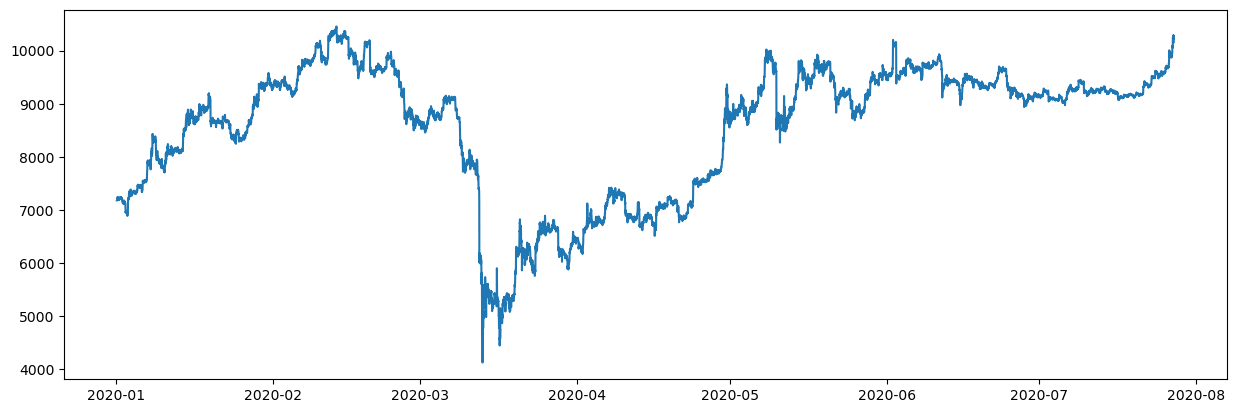

In [6]:
start = 0
end = 10000

to_plot = data[['datetime','close']][start:end]
to_plot = to_plot.set_index('datetime')
plt.figure().set_figwidth(15)
plt.plot(to_plot)
plt.show()

2.3 Generate popular indicators using the pandas-ta library

In [7]:
inds_list = data.ta.indicators(as_list = True)

if skip_feat_gen:
    data = pd.read_parquet('saved_features_'+period_postfix[period_width]+'.parquet')
    # truncate data to fit sentiment data
    data = data[:52500]
else:
    for ind in inds_list:
        clear_output(wait=True)
        # skip the indicators that returns an error
        if ind in ['above','mcgd','vwap']:
            continue
        temp_strat = ta.Strategy(name=ind,ta=[{'kind':ind}])
        data.ta.strategy(temp_strat,verbose=True)

In [8]:
# Save the data for later use
data.to_parquet('saved_features_'+period_postfix[period_width]+'.parquet')

Let's see how many of the indicators have too many null values, thus should be discarded.

In [9]:
null_counts = data.isna().sum()
indicators_to_drop = null_counts.index[null_counts>len(data)//10]
print('Indicators to be dropped:')
list(indicators_to_drop)

Indicators to be dropped:


['HILOl_13_21',
 'HILOs_13_21',
 'PSARl_0.02_0.2',
 'PSARs_0.02_0.2',
 'QQEl_14_5_4.236',
 'QQEs_14_5_4.236',
 'SUPERTl_7_3.0',
 'SUPERTs_7_3.0',
 'TD_SEQ_UP',
 'TD_SEQ_DN',
 'low_close',
 'mean_close',
 'high_close',
 'pos_volume',
 'neg_volume',
 'total_volume']

In [10]:
data = data.drop(indicators_to_drop,axis=1)
# backfill other null values in calculated indicators
data = data.bfill()

## 3 Feature Selection


Define the target to predict as the return in the next period.

Columns indicating whether the return will be positive (price up) or negative (price down) are also created. This is easier to predict than the precise value of return.

I found that predicting the return in next 4 period has better performance, so it is also calculated here (as target_2) for comparison later.

In [11]:
data['target'] = data['close'].shift(-1)
data['target'].ffill(inplace=True)
data['target'] = (data['target']-data['close'])/data['close']*100
data['target_2'] = data['close'].shift(-4)
data['target_2'].ffill(inplace=True)
data['target_2'] = (data['target_2']-data['close'])/data['close']*100

def calc_updown(x):
    if x>0:
        return 1
    else:
        return 0
    
def calc_updown_str(x):
    if x>0:
        return 'u'
    else:
        return 'd'
data['updown'] = data['target'].apply(calc_updown)
data['updown_2'] = data['target_2'].apply(calc_updown)
data['updown_str'] = data['target'].apply(calc_updown_str)
data['updown_2_str'] = data['target_2'].apply(calc_updown_str)
data['pre_target_2'] = data['target_2'].shift(4).fillna(0)
data['pre_updown_2'] = data['pre_target_2'].apply(calc_updown)


We set the first half of the data as training data and the second half as test data

In [12]:
train = data.loc[:len(data)//2]
test = data.loc[len(data)//2:]

In [13]:
X = train.drop(['datetime','target','updown','target_2','updown_2','DPO_20','updown_str','updown_2_str'],axis=1)
Y = train['updown_2']
X_fill = X.fillna(0)
corrs = X_fill.corrwith(Y)

Print the features with highest absolute correlation to target

In [14]:
corrs.sort_values().head(20)

WILLR_14          -0.083204
K_9_3             -0.078069
STOCHk_14_3_3     -0.075199
UO_7_14_28        -0.074815
CCI_14_0.015      -0.073821
J_9_3             -0.072387
BBP_5_2.0         -0.072376
CTI_12            -0.071107
TTM_TRND_6        -0.069254
D_9_3             -0.069043
STOCHd_14_3_3     -0.067825
AMATe_LR_8_21_2   -0.067586
EBSW_40_10        -0.067540
close_Z_30_1      -0.064217
ZS_30             -0.064217
CMO_14            -0.063160
RSI_14            -0.063160
FISHERT_9_1       -0.062921
pre_updown_2      -0.062452
PGO_14            -0.062373
dtype: float64

In [15]:
corrs.sort_values().tail(30)

TOS_STDEVALL_U_1            -0.000051
THERMOs_20_2_0.5             0.001571
SQZPRO_NO                    0.001609
SQZ_NO                       0.001609
ABER_ZG_5_15_XA_BBL_5_2.0    0.001652
PVOL                         0.001790
PVI_1                        0.002328
PVOh_12_26_9                 0.002608
ABER_ZG_5_15_B_BBL_5_2.0     0.002910
SQZ_OFF                      0.004852
PDIST                        0.005191
SQZPRO_ON_WIDE               0.007546
TRUERANGE_1                  0.008502
THERMO_20_2_0.5              0.010606
BBB_5_2.0                    0.011759
MASSI_9_25                   0.012923
DMN_14                       0.014138
ADX_14                       0.014199
NATR_14                      0.014589
volume                       0.018047
UI_14                        0.019468
PVO_12_26_9                  0.019712
PVOs_12_26_9                 0.022887
PVR                          0.044746
AOBV_SR_2                    0.044779
DEC_1                        0.047609
AROOND_14   

To ensure time sensitivity of the features, we plot the correlation between each feature and returns in future periods. If a decaying curve is observed, the feature probably contains time sensitive information about the return, and is thus useful for modeling.

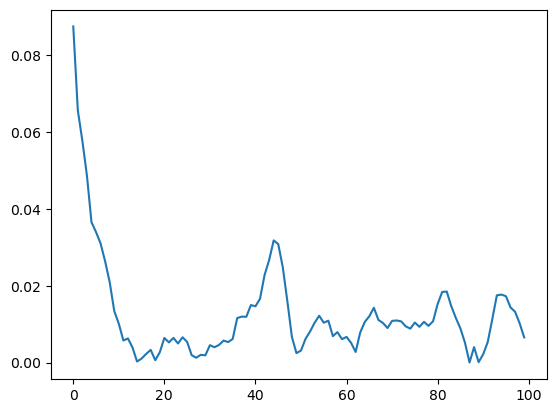

In [16]:
feat = 'WILLR_14'
train_feat = pd.DataFrame({})
Y = data['updown_2']
start = 0
end = 100
for i in range(start,end):
    train_feat[feat+"_"+str(i)] = data[feat].shift(i)
plt.plot(pd.Series(abs(train_feat.corrwith(Y)).values,[i for i in range(start,end)]))

We pre-select time sensitive features with good correlation.

In [17]:
pre_selected = corrs.index[(corrs<-0.025)|(corrs>0.025)].to_list()

Use a multicolinearity test to filter out multicolinear features, which most likely contain no new information.

In [18]:

selected = []
for feat in pre_selected:
    if not selected:
        selected.append(feat)
    else:
        X = train[selected].fillna(0)
        y = train[feat].fillna(0)
        score = LinearRegression().fit(X,y).score(X,y)
        if score < 0.81:
            selected.append(feat)
print(f'Selected {len(selected)} features for modeling.')

Selected 34 features for modeling.


In [19]:
selected

['ADOSC_3_10',
 'AMATe_LR_8_21_2',
 'AO_5_34',
 'AOBV_LR_2',
 'AROOND_14',
 'AROONU_14',
 'BBP_5_2.0',
 'BIAS_SMA_26',
 'BOP',
 'open_Z_30_1',
 'CG_10',
 'CMF_20',
 'CTI_12',
 'DEC_1',
 'EBSW_40_10',
 'EFI_13',
 'EOM_14_100000000',
 'BULLP_13',
 'BEARP_13',
 'KVO_34_55_13',
 'LOGRET_1',
 'MACDh_12_26_9',
 'MFI_14',
 'PPOh_12_26_9',
 'PSL_12',
 'PVR',
 'SMIo_5_20_5',
 'STC_10_12_26_0.5',
 'STCstoch_10_12_26_0.5',
 'SUPERTd_7_3.0',
 'TTM_TRND_6',
 'UO_7_14_28',
 'pre_target_2',
 'pre_updown_2']

## 4 Sentiment Analysis

Load comments in subreddit r/Bitcoin from a compressed file

In [20]:
subreddit_name = 'Bitcoin'
features_list = ['gilded','score', 'ups', 'stickied', 'author', 'distinguished', 'body', 'controversiality', 'created_utc', 'edited']
bool_feats = {'stickied','distinguished', 'controversiality',  'edited'}
str_feats = {'author','body'}

In [21]:
if not skip_sentiment_scoring:
    counter = 0
    scraped = {feat:[] for feat in features_list}
    with open(f"Reddit\\Downloaded_Data\\{subreddit_name}_comments.zst", 'rb') as fh:
        dctx = zstd.ZstdDecompressor(max_window_size=2147483648)
        with dctx.stream_reader(fh) as reader:
            previous_line = ""
            while True:

                chunk = reader.read(2**25)  # 16mb chunks
                if not chunk:
                    break

                string_data = chunk.decode('utf-8')
                lines = string_data.split("\n")
                for i, line in enumerate(lines[:-1]):
                    if i == 0:
                        line = previous_line + line
                    loaded = json.loads(line)
                    if loaded['body'] != '[deleted]' and loaded['body'] != '[removed]':
                        for feat in features_list:
                            if feat in loaded:
                                if feat == 'created_utc':
                                    scraped[feat].append(int(loaded[feat]))
                                elif feat in bool_feats:
                                    if loaded[feat]:
                                        scraped[feat].append(1)
                                    else:
                                        scraped[feat].append(0)
                                elif feat in str_feats:
                                    scraped[feat].append(str(loaded[feat]))
                                else:
                                    scraped[feat].append(loaded[feat])
                            else:
                                scraped[feat].append(None)

                previous_line = lines[-1]
                if len(scraped['author']) > 500000:
                    counter += 1
                    df = pd.DataFrame(scraped)
                    df.to_parquet(f"Reddit\\Downloaded_Data\\{subreddit_name}_comments_extracted_{counter}"+'.parquet')
                    scraped = {feat:[] for feat in features_list}
    counter += 1
    df = pd.DataFrame(scraped)
    df.to_parquet(f"Reddit\\Downloaded_Data\\{subreddit_name}_comments_extracted_{counter}"+'.parquet')

In [22]:
if not skip_sentiment_scoring:
    readed = []
    for i in range(1,27):
        readed.append(pd.read_parquet(f'Reddit\\Downloaded_Data\\Bitcoin_comments_extracted_{i}.parquet'))
    sentiment_data = pd.concat(readed,ignore_index=True)

Data cleaning: exclude comments from bots.

In [23]:
if not skip_sentiment_scoring:
    sentiment_data = sentiment_data[(sentiment_data['author'] != 'rBitcoinMod') & (sentiment_data['author'] != 'lntipbot')]

Use the pretrained FinBert model to score the sentiment data

In [24]:
pipe = pipeline(model="ProsusAI/finbert")


tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")
model.to("cuda")


# create a function to clean the tweets
def text_clean(data):
    # Remove &gt; and \n
    data = data.replace('&gt;',' ')
    data = data.replace('\n',' ')
    #I.  
    #1. Remove urls/hyperlinks
    data = re.sub(r'((www\.[^\s]+)|(http\S+))',' ', data)

    #2. Remove hashtags
    data = re.sub(r'#\w+', ' ', data)

    #3. Remove mentions 
    data = re.sub(r'@\w+',' ', data)

    #5. Remove additional white spaces
    data = re.sub('[\s]+', ' ', data)

    #II. 
    # Tokenize
    tweet_tokens = tokenizer.tokenize(data, return_tensors="pt")

    # Truncate long comments
    # Transformer models need not to remove stopwords, but it takes input tensors shorter than 512 only
    if len(tweet_tokens) > 510:
        for _ in range(len(tweet_tokens)-510):
            tweet_tokens.pop()

    # Joining
    result =  " ".join(tweet_tokens)
    
    # Remove Bert Tokenizer marks
    result = result.replace(' ##','')
    return result

# Define a function that computes sentiment score of the comment's text body
def sentiment_score(row):
    text = row['body']
    inputs = tokenizer(text, padding=True,return_tensors="pt")
    inputs = inputs.to("cuda")
    with torch.no_grad():
        logits = model(**inputs).logits
    logits_list = [float(logits[0][0]),float(logits[0][1]),float(logits[0][2])]
    e_logits = np.exp(logits_list)
    e_logits/=e_logits.sum()
    # positive, negative, neutral
    return e_logits

In [25]:
# The scoring process takes about 40 hours to complete
# It is skipped here because otherwise the notebook takes too long to run

if not skip_sentiment_scoring:
    start = datetime.now().timestamp()
    sentiment_data['body'] = sentiment_data['body'].apply(text_clean)
    sentiment_data[['positive','negative','neutral']] = sentiment_data.apply(sentiment_score,axis=1,result_type="expand")
    end = datetime.now().timestamp()
    print(f"Total time {round(end-start,2)} s")
    sentiment_data.to_parquet("Reddit\\sentiment_scored.parquet")
sentiment_data = pd.read_parquet("Reddit\\sentiment_scored.parquet")

Re-label the created datetime of comments for easy merging with market data.

In [26]:
sentiment_data['datetime'] = (sentiment_data['created_utc']//period_width)*period_width
sentiment_data['datetime'] = pd.to_datetime(sentiment_data['datetime'],unit='s')
sentiment_data['datetime'] = sentiment_data['datetime'].apply(str)
sentiment_data['datetime']

398455     2020-01-01 00:00:00
398456     2020-01-01 00:00:00
398457     2020-01-01 00:00:00
398458     2020-01-01 00:00:00
398459     2020-01-01 00:00:00
                  ...         
4940263    2022-12-31 23:30:00
4940264    2022-12-31 23:30:00
4940265    2022-12-31 23:30:00
4940266    2022-12-31 23:30:00
4940267    2022-12-31 23:30:00
Name: datetime, Length: 4541813, dtype: object

In [27]:
# add sentiment scores to data
sentiment_grouped = sentiment_data[['datetime','score']].groupby(['datetime'],as_index=False).count()
sentiment_grouped.rename({'score':'count'},axis=1,inplace=True)
numeric_list = ['positive','negative']
for numeric in numeric_list:
    sentiment_grouped[numeric+'_mean'] = sentiment_data[['datetime',numeric]].groupby(['datetime'],as_index=False).mean()[numeric]
sentiment_grouped['datetime'] = sentiment_grouped['datetime'].apply(datetime.strptime,args=['%Y-%m-%d %H:%M:%S'])
data = data.merge(sentiment_grouped[['datetime','positive_mean','negative_mean']],how = 'left',on='datetime')
data['positive_mean'] = data['positive_mean'].fillna(0)
data['negative_mean'] = data['negative_mean'].fillna(0)

# train test split again
train = data.loc[:len(data)//2]
test = data.loc[len(data)//2:]

In [28]:
data

,datetime,open,high,low,close,volume,ABER_ZG_5_15,ABER_SG_5_15,ABER_XG_5_15,ABER_ATR_5_15,...,target,target_2,updown,updown_2,updown_str,updown_2_str,pre_target_2,pre_updown_2,positive_mean,negative_mean
0,2020-01-01 05:30:00,7195.24,7196.25,7175.47,7178.45,331.185522,7201.455333,7243.609268,7206.206732,18.701268,...,-0.019921,0.691514,0,1,d,u,0.000000,0,0.056984,0.144473
1,2020-01-01 06:00:00,7178.19,7185.44,7175.46,7177.02,180.629379,7201.455333,7243.609268,7206.206732,18.701268,...,0.488782,0.917233,1,1,u,u,0.000000,0,0.108788,0.197575
2,2020-01-01 06:30:00,7176.47,7217.00,7175.71,7212.10,355.063574,7201.455333,7243.609268,7206.206732,18.701268,...,0.057819,0.347333,1,1,u,u,0.000000,0,0.081976,0.145667
3,2020-01-01 07:00:00,7212.10,7230.00,7204.28,7216.27,527.989029,7201.455333,7243.609268,7206.206732,18.701268,...,0.163797,0.121115,1,1,u,u,0.000000,0,0.053289,0.138540
4,2020-01-01 07:30:00,7215.52,7238.88,7211.41,7228.09,309.018157,7201.455333,7243.609268,7206.206732,18.701268,...,0.204203,-0.081073,1,0,u,d,0.691514,1,0.051358,0.064254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52495,2022-12-29 21:00:00,16632.25,16640.34,16607.98,16616.60,3590.081590,16627.328000,16665.210623,16589.445377,37.882623,...,0.125357,-0.000782,1,0,u,d,-0.001444,0,0.100425,0.116447
52496,2022-12-29 21:30:00,16616.60,16639.00,16606.44,16637.43,3793.382450,16628.730667,16666.258448,16591.202885,37.527781,...,-0.032277,-0.125981,0,0,d,d,0.098128,1,0.079047,0.153252
52497,2022-12-29 22:00:00,16637.83,16654.54,16630.00,16632.06,3402.070210,16632.800000,16669.461929,16596.138071,36.661929,...,-0.071549,-0.093735,0,0,d,d,0.015214,1,0.097918,0.136395
52498,2022-12-29 22:30:00,16632.06,16639.16,16619.23,16620.16,2694.889590,16631.121333,16666.667801,16595.574866,35.546467,...,-0.022202,-0.022202,0,0,d,d,-0.075634,0,0.072135,0.085994


We will use positive and negative scores for modeling. Let's make sure they are not multicolinear with selected technical features.

In [29]:
for feat in ['positive_mean','negative_mean']:
    X = train[selected].fillna(0)
    y = train[feat].fillna(0)
    score = LinearRegression().fit(X,y).score(X,y)
    print(f'R^2 of {feat} is {score}.')

R^2 of positive_mean is 0.016324381839388558.
R^2 of negative_mean is 0.02043227094922162.


In [30]:
selected += ['positive_mean','negative_mean']

## 5 Modeling and Strategy

I use LGBM Classifier as a baseline model. It gives us an idea how far can a "simple and straightforward" model go.

In [31]:
lgb_params = {
        "objective": "binary",
        "n_estimators": 1000,
        "num_leaves": 256,
        "subsample": 0.6,
        "colsample_bytree": 0.8,
        "learning_rate": 0.001,
        'max_depth': 20,
        "n_jobs": -1,
#         "device": "gpu",
        "verbosity": -1,
        "importance_type": "gain",
        "reg_alpha": 0.01,
        "reg_lambda": 0.1
    }
models = []
X = train[selected].fillna(0)
Y = train['updown_2'].fillna(0)
X_train = X[:X.shape[0]//5*4]
Y_train = Y[:X.shape[0]//5*4]
X_valid = X[X.shape[0]//5*4:]
Y_valid = Y[X.shape[0]//5*4:]

#Normalize
X_mean = X_train.mean()
X_std = X_train.std()
X_train = (X_train-X_mean)/X_std
X_valid = (X_valid-X_mean)/X_std

In [32]:
classify_model = lgb.LGBMClassifier(**lgb_params)
classify_model.fit(
    X_train,
    Y_train,
    eval_set=[(X_train,Y_train),(X_valid, Y_valid)],
    callbacks=[
        lgb.callback.early_stopping(stopping_rounds=1000),
        lgb.callback.log_evaluation(period=100),
    ],
)

Training until validation scores don't improve for 1000 rounds
[100]	training's binary_logloss: 0.679014	valid_1's binary_logloss: 0.694543
[200]	training's binary_logloss: 0.666968	valid_1's binary_logloss: 0.69443
[300]	training's binary_logloss: 0.655307	valid_1's binary_logloss: 0.694451
[400]	training's binary_logloss: 0.644175	valid_1's binary_logloss: 0.694462
[500]	training's binary_logloss: 0.633505	valid_1's binary_logloss: 0.694387
[600]	training's binary_logloss: 0.62312	valid_1's binary_logloss: 0.694475
[700]	training's binary_logloss: 0.613124	valid_1's binary_logloss: 0.694588
[800]	training's binary_logloss: 0.60348	valid_1's binary_logloss: 0.6949
[900]	training's binary_logloss: 0.59414	valid_1's binary_logloss: 0.695252
[1000]	training's binary_logloss: 0.585047	valid_1's binary_logloss: 0.695531
Did not meet early stopping. Best iteration is:
[474]	training's binary_logloss: 0.636246	valid_1's binary_logloss: 0.694362


LGBMClassifier(colsample_bytree=0.8, importance_type='gain',
               learning_rate=0.001, max_depth=20, n_estimators=1000, n_jobs=-1,
               num_leaves=256, objective='binary', reg_alpha=0.01,
               reg_lambda=0.1, subsample=0.6, verbosity=-1)

Plot the training and validation loss of the LGBM model. It helps us understand how severely the model is overfitting to the training data.

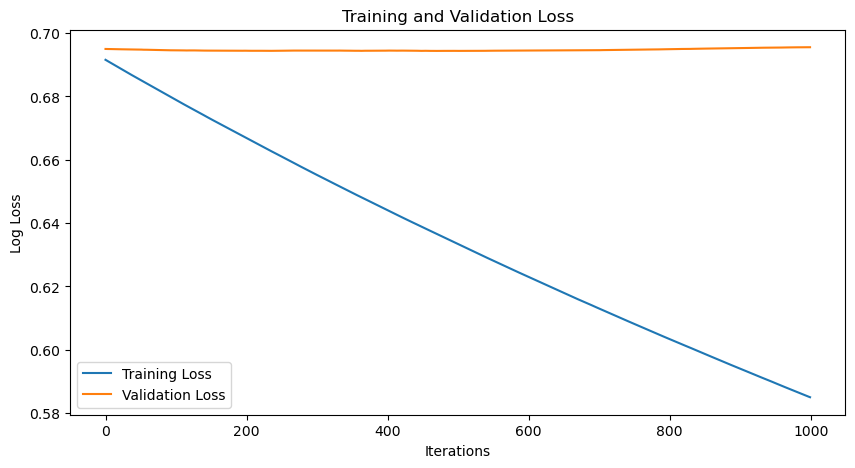

In [33]:
evals_result = classify_model.evals_result_

# Extract training and validation loss
train_loss = evals_result['training']['binary_logloss']
val_loss = evals_result['valid_1']['binary_logloss']

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

Build a strategy based on the prediction by the LGBM model. (TBD)

In [34]:
backtest_df = test.reset_index()

X_test = test[selected].fillna(0)
X_test = (X_test-X_mean)/X_std
lgb_pred = classify_model.predict_proba(X_test)
backtest_df['LGB_prediction'] = lgb_pred.T[1]
backtest_df = backtest_df.set_index('datetime')

to_backtest = backtest_df[['open','high','low','close','volume']].rename({'open':'Open','high':'High','low':'Low','close':'Close','volume':'Volume'},axis=1)

import backtesting as bti

def lgb():
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return backtest_df['LGB_prediction']


class TestStrategy_no_exit(bti.Strategy):
    def init(self):
        self.lgb = self.I(lgb)
        self.counter = 0
    def next(self):
        if self.counter > 0:
            self.counter -= 1
        else:
            self.position.close()
            if self.lgb[-1] >0.58:
                self.position.close()
                self.buy(size=0.999)
                self.counter = 3
            if self.lgb[-1] <0.42:
                self.position.close()
                self.sell(size=0.999)
                self.counter = 3
                
bt = bti.Backtest(to_backtest, TestStrategy_no_exit, cash=100000, commission=0.00025,exclusive_orders=True)
stats = bt.run()
stats

Loading BokehJS ...

Start                     2021-07-01 02:30:00
End                       2022-12-29 23:00:00
Duration                    546 days 20:30:00
Exposure Time [%]                    19.68381
Equity Final [$]                 146042.55749
Equity Peak [$]                 150570.290782
Return [%]                          46.042557
Buy & Hold Return [%]              -52.316033
Return (Ann.) [%]                   30.219286
Volatility (Ann.) [%]               32.720592
Sharpe Ratio                         0.923556
Sortino Ratio                        1.946582
Calmar Ratio                         1.536988
Max. Drawdown [%]                  -19.661366
Avg. Drawdown [%]                   -1.324836
Max. Drawdown Duration      220 days 21:00:00
Avg. Drawdown Duration        6 days 02:02:00
# Trades                                 1065
Win Rate [%]                         53.42723
Best Trade [%]                       9.003252
Worst Trade [%]                     -5.829889
Avg. Trade [%]                    

From the validation score we can tell that the model hardly learns anything useful from the data, but overfits to the training data a lot. From the backtest we also see that the model hardly make any profit in the 1.5 year test period. We hope to do better with an LSTM model.

Now, let's try LSTM model

In [35]:
target_name = 'updown_2'
num_batches = 1 # must divide size of train and valid


import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

X = train[selected].fillna(0)
Y = train[target_name].fillna(0)
X_test = test[selected].fillna(0)
Y_test = test[target_name].fillna(0)
X_train = X[:X.shape[0]//5*4]
Y_train = Y[:X.shape[0]//5*4]
X_valid = X[X.shape[0]//5*4:]
Y_valid = Y[X.shape[0]//5*4:]

#Normalize
X_mean = X_train.mean()
X_std = X_train.std()
X_train = (X_train-X_mean)/X_std
X_valid = (X_valid-X_mean)/X_std

import torch
import torch.nn as nn
import torch.optim as optim
import gc
import numpy as np

gc.collect()

# torch.cuda.empty_cache()

def split_dataframe(df, chunk_size = 10000): 
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks



class LSTMPredictor(nn.Module):
    def __init__(self, n_features=29, n_hidden=50, n_layers=2, dropout_rate=0.1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers,
            dropout=dropout_rate, # Apply dropout only if there are multiple LSTM layers
        )
        self.regressor = nn.Linear(n_hidden, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        out, (hidden, _) = self.lstm(x)
        preds = self.regressor(out)
        preds = self.sigmoid(preds)
        return preds
    
input_size = len(selected)  # Number of features
hidden_size = 200  # Number of hidden units
num_layers = 2  # Number of LSTM layers
dropout_rate = 0.1  # Output size (predicted stock price)
device=torch.device("cuda")

if (len(X_train) % num_batches != 0) or (len(X_valid) % num_batches != 0):
    raise ValueError('num_batches must divide size of train and valid')

model = LSTMPredictor(input_size, hidden_size, num_layers, dropout_rate)
model.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)


X_train_tensor = torch.tensor(np.array_split(X_train.values,num_batches),dtype=torch.float32)
y_train_tensor = torch.tensor(np.array_split(Y_train.values.reshape(-1,1),num_batches),dtype=torch.float32)
X_val_tensor = torch.tensor(np.array_split(X_valid.values,num_batches),dtype=torch.float32)
y_val_tensor = torch.tensor(np.array_split(Y_valid.values.reshape(-1,1),num_batches),dtype=torch.float32)

num_epochs = 50
original_loss = 0
for epoch in range(num_epochs):
    model.train()
    outputs = model(X_train_tensor.to(device))
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    if epoch == 0:
        original_loss = loss.item()
    else:
        if loss.item()<original_loss*0.9:
            break



Epoch 1/50, Loss: 0.6956439018249512
Epoch 2/50, Loss: 0.6916703581809998
Epoch 3/50, Loss: 0.6924543976783752
Epoch 4/50, Loss: 0.6895654797554016
Epoch 5/50, Loss: 0.6883047819137573
Epoch 6/50, Loss: 0.6860198378562927
Epoch 7/50, Loss: 0.6846520304679871
Epoch 8/50, Loss: 0.6845692992210388
Epoch 9/50, Loss: 0.6819543838500977
Epoch 10/50, Loss: 0.6814253926277161
Epoch 11/50, Loss: 0.6802869439125061
Epoch 12/50, Loss: 0.6793287992477417
Epoch 13/50, Loss: 0.6773619055747986
Epoch 14/50, Loss: 0.6758898496627808
Epoch 15/50, Loss: 0.6743555665016174
Epoch 16/50, Loss: 0.6715816259384155
Epoch 17/50, Loss: 0.6705424189567566
Epoch 18/50, Loss: 0.6729181408882141
Epoch 19/50, Loss: 0.6679166555404663
Epoch 20/50, Loss: 0.6683567762374878
Epoch 21/50, Loss: 0.6631539463996887
Epoch 22/50, Loss: 0.6613410711288452
Epoch 23/50, Loss: 0.6579863429069519
Epoch 24/50, Loss: 0.6525700092315674
Epoch 25/50, Loss: 0.6490637063980103
Epoch 26/50, Loss: 0.6439711451530457
Epoch 27/50, Loss: 0.

Check the validation score and compare it with the training score. If the validation loss is not significant higher than the training loss, then the overfit is weak, meaning that we can trust the model.

In [36]:
# Validate the model
X_val_tensor = torch.tensor(np.array_split(X_valid.values,num_batches),dtype=torch.float32)
y_val_tensor = torch.tensor(np.array_split(Y_valid.values.reshape(-1,1),num_batches),dtype=torch.float32)

model.eval()

X1 = X_valid.copy()
X1 = X1.reset_index()
X1['zero'] = 0
Y1 = X1['zero']
with torch.no_grad():
    trivial_loss = criterion(torch.tensor(np.array_split(Y1.values.reshape(-1,1),num_batches),dtype=torch.float32).to(device), y_val_tensor.to(device))
    print(f'Trivial prediction Loss: {trivial_loss.item()}')
with torch.no_grad():
    y_pred = model(X_val_tensor.to(device))
    test_loss = criterion(y_pred, y_val_tensor.to(device))
    print(f'LSTM prediction Loss: {test_loss.item()}')
pred_list = []
for i in range(y_pred.shape[0]):
    pred_list += y_pred[i].transpose(-1,0)[0].tolist()
X1['LSTM_predictions'] = pd.Series(pred_list).values
X1[target_name] = Y_valid.reset_index()[target_name]

Trivial prediction Loss: 49.64768600463867
LSTM prediction Loss: 0.7523108124732971


Plot distributions of LSTM prediction

<Axes: >

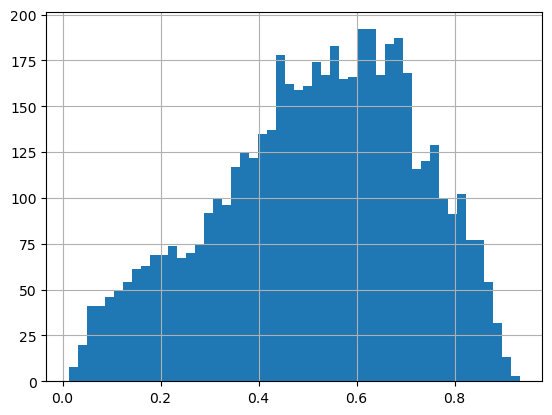

In [37]:
X1['LSTM_predictions'].hist(bins=50)

Define a strategy to buy if LSTM model has good confidence that price will go up, sell if price will go down.

In [38]:
#remember to reset index
backtest_df = test.reset_index()
num_test_batches = 1

if backtest_df.index[0] != 0:
    raise ValueError("Remember to reset index!")
batch_size = len(train)//num_batches
backtest_df = backtest_df[:batch_size*num_test_batches]
X_test = backtest_df[selected].fillna(0)
X_test = (X_test-X_mean)/X_std
X_test_tensor = torch.tensor(np.array_split(X_test.values,num_test_batches),dtype=torch.float32)
with torch.no_grad():
    y_pred = model(X_test_tensor.to(device))
pred_list = []
for i in range(y_pred.shape[0]):
    pred_list += y_pred[i].transpose(-1,0)[0].tolist()
backtest_df['LSTM_prediction'] = pd.Series(pred_list).values
backtest_df = backtest_df.set_index('datetime')

to_backtest = backtest_df[['open','high','low','close','volume']].rename({'open':'Open','high':'High','low':'Low','close':'Close','volume':'Volume'},axis=1)

import backtesting as bti

def lstm():
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return backtest_df['LSTM_prediction']

class TestStrategy_no_exit(bti.Strategy):
    def init(self):
        self.lstm = self.I(lstm)
        self.counter = 0
    def next(self):
        if self.counter > 0:
            self.counter -= 1
        else:
            self.position.close()
            if self.lstm[-1] >0.8:
                self.position.close()
                self.buy(size=0.999)
                self.counter = 3
            if self.lstm[-1] <0.2:
                self.position.close()
                self.sell(size=0.999)
                self.counter = 3
                
bt = bti.Backtest(to_backtest, TestStrategy_no_exit, cash=100000, commission=0.00025,exclusive_orders=True)
stats = bt.run()
stats

Start                     2021-07-01 02:30:00
End                       2022-12-29 23:00:00
Duration                    546 days 20:30:00
Exposure Time [%]                   16.468571
Equity Final [$]                231708.966682
Equity Peak [$]                  234553.11437
Return [%]                         131.708967
Buy & Hold Return [%]              -52.316033
Return (Ann.) [%]                   75.660411
Volatility (Ann.) [%]               47.976828
Sharpe Ratio                          1.57702
Sortino Ratio                        5.898445
Calmar Ratio                         4.778904
Max. Drawdown [%]                  -15.832167
Avg. Drawdown [%]                   -1.375587
Max. Drawdown Duration      110 days 03:00:00
Avg. Drawdown Duration        4 days 21:58:00
# Trades                                  915
Win Rate [%]                        54.098361
Best Trade [%]                       9.003252
Worst Trade [%]                     -5.645512
Avg. Trade [%]                    

As comparison, let's test the performance of the same model without using sentiment data

In [39]:
selected_no_sentiment = []
for key in selected:
    if key not in {'positive_mean','negative_mean'}:
        selected_no_sentiment.append(key)

X = train[selected_no_sentiment].fillna(0)
Y = train[target_name].fillna(0)
X_test = test[selected_no_sentiment].fillna(0)
Y_test = test[target_name].fillna(0)
X_train = X[:X.shape[0]//5*4]
Y_train = Y[:X.shape[0]//5*4]
X_valid = X[X.shape[0]//5*4:]
Y_valid = Y[X.shape[0]//5*4:]

#Normalize
X_mean = X_train.mean()
X_std = X_train.std()
X_train = (X_train-X_mean)/X_std
X_valid = (X_valid-X_mean)/X_std
        
input_size = len(selected_no_sentiment)  # Number of features
hidden_size = 200  # Number of hidden units
num_layers = 2  # Number of LSTM layers
dropout_rate = 0.1  # Output size (predicted stock price)
device=torch.device("cuda")

if (len(X_train) % num_batches != 0) or (len(X_valid) % num_batches != 0):
    raise ValueError('num_batches must divide size of train and valid')

model2 = LSTMPredictor(input_size, hidden_size, num_layers, dropout_rate)
model2.to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model2.parameters(), lr=0.005)


X_train_tensor = torch.tensor(np.array_split(X_train.values,num_batches),dtype=torch.float32)
y_train_tensor = torch.tensor(np.array_split(Y_train.values.reshape(-1,1),num_batches),dtype=torch.float32)
X_val_tensor = torch.tensor(np.array_split(X_valid.values,num_batches),dtype=torch.float32)
y_val_tensor = torch.tensor(np.array_split(Y_valid.values.reshape(-1,1),num_batches),dtype=torch.float32)

num_epochs = 50
original_loss = 0
for epoch in range(num_epochs):
    model2.train()
    outputs = model2(X_train_tensor.to(device))
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensor.to(device))
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')
    if epoch == 0:
        original_loss = loss.item()
    else:
        if loss.item()<original_loss*0.9:
            break


Epoch 1/50, Loss: 0.6937562227249146
Epoch 2/50, Loss: 0.6951528787612915
Epoch 3/50, Loss: 0.6910202503204346
Epoch 4/50, Loss: 0.6910021305084229
Epoch 5/50, Loss: 0.6896952986717224
Epoch 6/50, Loss: 0.6883860230445862
Epoch 7/50, Loss: 0.6868770718574524
Epoch 8/50, Loss: 0.6863532066345215
Epoch 9/50, Loss: 0.6858006715774536
Epoch 10/50, Loss: 0.684343159198761
Epoch 11/50, Loss: 0.68327796459198
Epoch 12/50, Loss: 0.6826754212379456
Epoch 13/50, Loss: 0.6813283562660217
Epoch 14/50, Loss: 0.6805291771888733
Epoch 15/50, Loss: 0.6815903186798096
Epoch 16/50, Loss: 0.6783243417739868
Epoch 17/50, Loss: 0.679004430770874
Epoch 18/50, Loss: 0.6758667826652527
Epoch 19/50, Loss: 0.6747992634773254
Epoch 20/50, Loss: 0.6731627583503723
Epoch 21/50, Loss: 0.671206533908844
Epoch 22/50, Loss: 0.6691531538963318
Epoch 23/50, Loss: 0.6666956543922424
Epoch 24/50, Loss: 0.6640926003456116
Epoch 25/50, Loss: 0.6594540476799011
Epoch 26/50, Loss: 0.6720123887062073
Epoch 27/50, Loss: 0.66365

Check severity of overfitting by checking the validation score:

In [40]:
# Validate the model
X_val_tensor = torch.tensor(np.array_split(X_valid.values,num_batches),dtype=torch.float32)
y_val_tensor = torch.tensor(np.array_split(Y_valid.values.reshape(-1,1),num_batches),dtype=torch.float32)

model2.eval()

X1 = X_valid.copy()
X1 = X1.reset_index()
X1['zero'] = 0
Y1 = X1['zero']
with torch.no_grad():
    trivial_loss = criterion(torch.tensor(np.array_split(Y1.values.reshape(-1,1),num_batches),dtype=torch.float32).to(device), y_val_tensor.to(device))
    print(f'Trivial prediction Loss: {trivial_loss.item()}')
with torch.no_grad():
    y_pred = model2(X_val_tensor.to(device))
    test_loss = criterion(y_pred, y_val_tensor.to(device))
    print(f'LSTM prediction Loss: {test_loss.item()}')
pred_list = []
for i in range(y_pred.shape[0]):
    pred_list += y_pred[i].transpose(-1,0)[0].tolist()
X1['LSTM_predictions'] = pd.Series(pred_list).values
X1[target_name] = Y_valid.reset_index()[target_name]

Trivial prediction Loss: 49.64768600463867
LSTM prediction Loss: 0.7867146134376526


<Axes: >

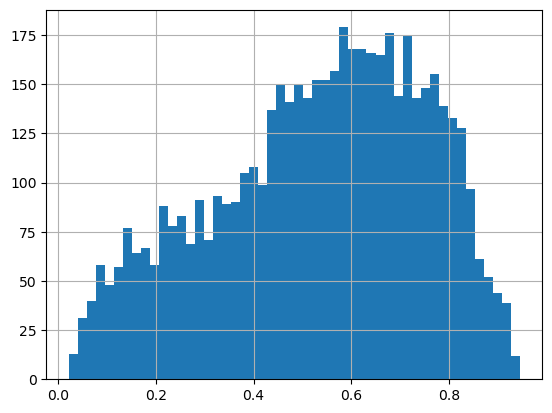

In [41]:
X1['LSTM_predictions'].hist(bins=50)

Backtesting for model without sentiment data:

In [42]:
#remember to reset index
backtest_df = test.reset_index()
num_test_batches = 6

if backtest_df.index[0] != 0:
    raise ValueError("Remember to reset index!")
batch_size = len(train)//num_batches
backtest_df = backtest_df[:batch_size*num_test_batches]
X_test = backtest_df[selected_no_sentiment].fillna(0)
X_test = (X_test-X_mean)/X_std
X_test_tensor = torch.tensor(np.array_split(X_test.values,num_test_batches),dtype=torch.float32)
with torch.no_grad():
    y_pred = model2(X_test_tensor.to(device))
pred_list = []
for i in range(y_pred.shape[0]):
    pred_list += y_pred[i].transpose(-1,0)[0].tolist()
backtest_df['LSTM_prediction'] = pd.Series(pred_list).values
backtest_df = backtest_df.set_index('datetime')

to_backtest = backtest_df[['open','high','low','close','volume']].rename({'open':'Open','high':'High','low':'Low','close':'Close','volume':'Volume'},axis=1)

import backtesting as bti

def lstm():
    """
    Return simple moving average of `values`, at
    each step taking into account `n` previous values.
    """
    return backtest_df['LSTM_prediction']

class TestStrategy_early_exit(bti.Strategy):
    def init(self):
        self.lstm = self.I(lstm)
        self.counter = 0
    def next(self):
        if self.lstm[-1] >0.58:
            self.position.close()
            self.buy(size=0.999)
            self.counter = 1
        elif self.lstm[-1] <0.38:
            self.position.close()
            self.sell(size=0.999)
            self.counter = 1
        else:
            self.counter -= 1
            if self.counter == 0:
                self.position.close()

class TestStrategy_no_exit(bti.Strategy):
    def init(self):
        self.lstm = self.I(lstm)
        self.counter = 0
    def next(self):
        if self.counter > 0:
            self.counter -= 1
        else:
            self.position.close()
            if self.lstm[-1] >0.85:
                self.position.close()
                self.buy(size=0.999)
                self.counter = 3
            if self.lstm[-1] <0.2:
                self.position.close()
                self.sell(size=0.999)
                self.counter = 3
                
bt = bti.Backtest(to_backtest, TestStrategy_no_exit, cash=100000, commission=0.00025,exclusive_orders=True)
stats = bt.run()
stats

Start                     2021-07-01 02:30:00
End                       2022-12-29 23:00:00
Duration                    546 days 20:30:00
Exposure Time [%]                    16.63619
Equity Final [$]                140555.517527
Equity Peak [$]                 140881.480727
Return [%]                          40.555518
Buy & Hold Return [%]              -52.316033
Return (Ann.) [%]                   25.849387
Volatility (Ann.) [%]               28.517619
Sharpe Ratio                         0.906436
Sortino Ratio                        2.062888
Calmar Ratio                         1.673122
Max. Drawdown [%]                   -15.44979
Avg. Drawdown [%]                   -1.342435
Max. Drawdown Duration      240 days 02:00:00
Avg. Drawdown Duration        7 days 03:09:00
# Trades                                  917
Win Rate [%]                        54.634678
Best Trade [%]                       4.636676
Worst Trade [%]                     -4.700358
Avg. Trade [%]                    